# Integration with Artificial Thymic Organoid data

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys,os
import scvi
import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import scipy

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scvelo as scv

In [5]:
## import utils
cwd = '.'
sys.path.append(cwd)

import map_query_utils

In [6]:
figdir = "/home/jovyan/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/invivoVSinvitro/"
if os.path.exists(figdir):
    sc.settings.figdir = figdir
    scv.settings.figdir = figdir
else:
    os.mkdir(figdir)
    sc.settings.figdir = figdir
    scv.settings.figdir = figdir


In [7]:
## r2py setup
import anndata2ri
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

anndata2ri.activate()

In [8]:
%load_ext rpy2.ipython


In [9]:
%%R
library(tidyverse)
library(reshape2)
library(patchwork)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

In [10]:
def _plot_sorted_violin(merged_adata_bcells, groupby, y_value):
    n_cells_anno = merged_adata_bcells.obs[[groupby,y_value]].value_counts(groupby)
    keep_anno = n_cells_anno.index[n_cells_anno > 30]

    mean_sim = merged_adata_bcells.obs[[groupby,y_value]].groupby(groupby).mean()
    anno_order = mean_sim.loc[keep_anno].sort_values(y_value, ascending=False).index.tolist()

    merged_adata_bcells.var_names_make_unique()
    sc.pl.violin(merged_adata_bcells[merged_adata_bcells.obs[groupby].isin(keep_anno)], 
                                     y_value, groupby=groupby, rotation=90, 
                                     order=anno_order)

## Prepare data for mapping 

### Load dataset

Provided by Chenqu, and re-saved by me to have EnsemblIDs as `var_names`

In [247]:
ato_data_dir = "/lustre/scratch117/cellgen/team205/cs42/jovyan_25082021/thymic_organoid_new/matrix/"
metadata_file = '/lustre/scratch117/cellgen/team205/cs42/jovyan_25082021/thymic_organoid_new/manifest/metadata_v4.csv'
keep_samples = ['6180STDY9448808', '6180STDY9448811', '6180STDY9448813']

In [248]:
ato_metadata = pd.read_csv(metadata_file)

In [249]:
def simple_filtering_pp(adata, min_n_count = 2000, min_n_gene = 500, max_n_gene = 7000):
    import scrublet as scr
    # caculate n_counts / n_genes per cell
    adata.obs['n_counts'] = np.sum(adata.X, axis=1).A1
    adata.obs['n_genes'] = np.sum(adata.X>0,axis=1)

    print("Filtering cells...")
    clist = []
    clist.append(np.array(adata.obs['n_counts'] > min_n_count))
    clist.append(np.array(adata.obs['n_genes'] > min_n_gene))
    clist.append(np.array(adata.obs['n_genes'] < max_n_gene))

    c = np.column_stack(clist).all(axis=1)
    adata = adata[c].copy()

    adata = adata[:,np.argsort(adata.var.gene_ids)]

    mito_genes = adata.var_names.str.startswith('MT-')
    adata.obs['mito'] = (np.sum(adata.X[:, mito_genes],axis=1).A1) / (np.sum(adata.X,axis=1).A1)
    
    ## Find mouse cells
    adata.var['human'] = adata.var_names.str.startswith('GRCh38')
    adata.var['mouse'] = adata.var_names.str.startswith('mm10_')
     
    sc.pp.calculate_qc_metrics(adata, qc_vars=["human"], inplace=True)
    adata.obs['human_cells'] = adata.obs['pct_counts_human'] > 0.9
    
    print("Computing doublets...")
    scrub = scr.Scrublet(adata.X)
    if adata.shape[0] < 30:
        doublet_scores, predicted_doublets = scrub.scrub_doublets(verbose=False, n_prin_comps=adata.shape[0] - 1)
    else:
        doublet_scores, predicted_doublets = scrub.scrub_doublets(verbose=False)
    adata.obs['doublet_scores'] = doublet_scores
    adata.obs['predicted_doublets'] = predicted_doublets
    return(adata)

In [250]:
adata_ls = []
for s in keep_samples:
    ato_adata = sc.read_10x_mtx(ato_data_dir + s + "/raw")
    ato_adata = simple_filtering_pp(ato_adata)
    ato_adata.obs["sequence_name"] = s
    adata_ls.append(ato_adata)

for adata in adata_ls:
    ## Find mouse cells
    adata.var['human'] = adata.var_names.str.startswith('GRCh38')
    adata.var['mouse'] = adata.var_names.str.startswith('mm10_')
     
    sc.pp.calculate_qc_metrics(adata, qc_vars=["human"], inplace=True)
    adata.obs['human_cells'] = adata.obs['pct_counts_human'] > 0.9

# ## Save barcodes for human cells
# bcdir = '/nfs/team205/ed6/data/Fetal_immune/barcodes4souporcell/'
# for a in adata_ls:
#     s = a.obs['sequence_name'].unique()[0]
#     outdir = bcdir + s + "/"
#     if not os.path.exists(outdir):
#         os.mkdir(outdir)
#     file = outdir + 'human_barcodes.csv'
#     with open(file, 'w') as f:
#         for bc in a.obs_names[a.obs["human_cells"]].tolist():
#             f.write("%s\n" % bc)

## Restrict to human cells
adata_ls = [a[a.obs['human_cells']].copy() for a in adata_ls]

## Add metadata
for a in adata_ls:
    merged_obs = pd.merge(a.obs, ato_metadata)
    merged_obs.index = a.obs_names
    a.obs = merged_obs.copy()

Trying to set attribute `.obs` of view, copying.


Filtering cells...
Computing doublets...


Trying to set attribute `.obs` of view, copying.


Filtering cells...
Computing doublets...
Filtering cells...


Trying to set attribute `.obs` of view, copying.


Computing doublets...


In [251]:
for a in adata_ls:
    a.obs_names = a.obs_names + "_" + a.obs["sequence_name"]

In [252]:
ato_adata = anndata.concat(adata_ls)

In [253]:
## Filter genes
ato_adata = ato_adata[:,ato_adata.var_names.str.startswith("GRCh")].copy()
ato_adata.var_names = [x[1] for x in ato_adata.var_names.str.split("GRCh38_")]

### QC and exploration

In [90]:
ato_adata_pp = ato_adata.copy()
sc.pp.normalize_per_cell(ato_adata_pp)
sc.pp.log1p(ato_adata_pp)
sc.pp.scale(ato_adata_pp)
sc.pp.pca(ato_adata_pp)
sc.pp.neighbors(ato_adata_pp)
sc.tl.umap(ato_adata_pp)
# adata.obsm["X_pca"] = ato_adata_pp.obsm["X_pca"].copy()
# adata.obsm["X_umap"] = ato_adata_pp.obsm["X_umap"].copy()

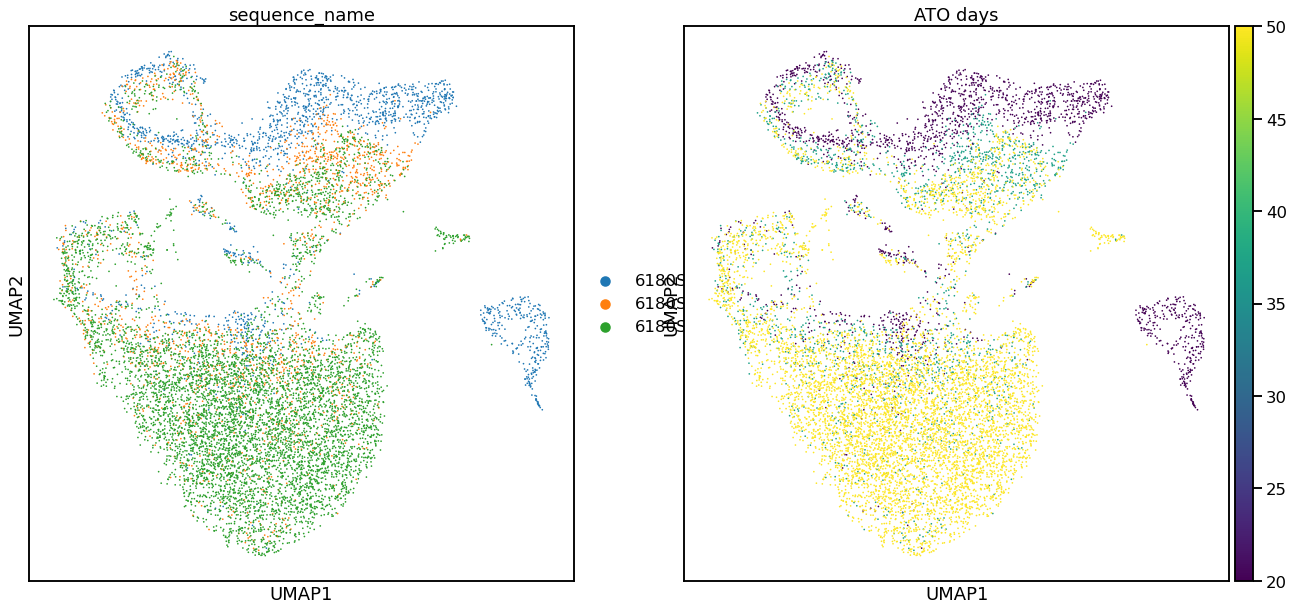

In [91]:
sc.pl.umap(ato_adata_pp, color=['sequence_name', "ATO days"])

In [92]:
# ## Load NK/T markers
# def plot_markers(adata, markers_df, ct):
#     ct_markers = markers_df.gene[markers_df.anno_lvl_2==ct]
#     sc.pl.umap(adata, color=ct_markers[ct_markers.isin(adata.var_names)])
    
# nkt_markers = pd.read_csv("../../metadata/marker_genes/NKT_marker_genes_09072021_clean.csv", index_col=0)

In [93]:
## Load annotated data by Chenqu
ato_adata_cs42 = sc.read_h5ad('/lustre/scratch117/cellgen/team205/cs42/jovyan_25082021/thymic_organoid_new/write/ATO.A05.v01.merged_annotated.h5ad')

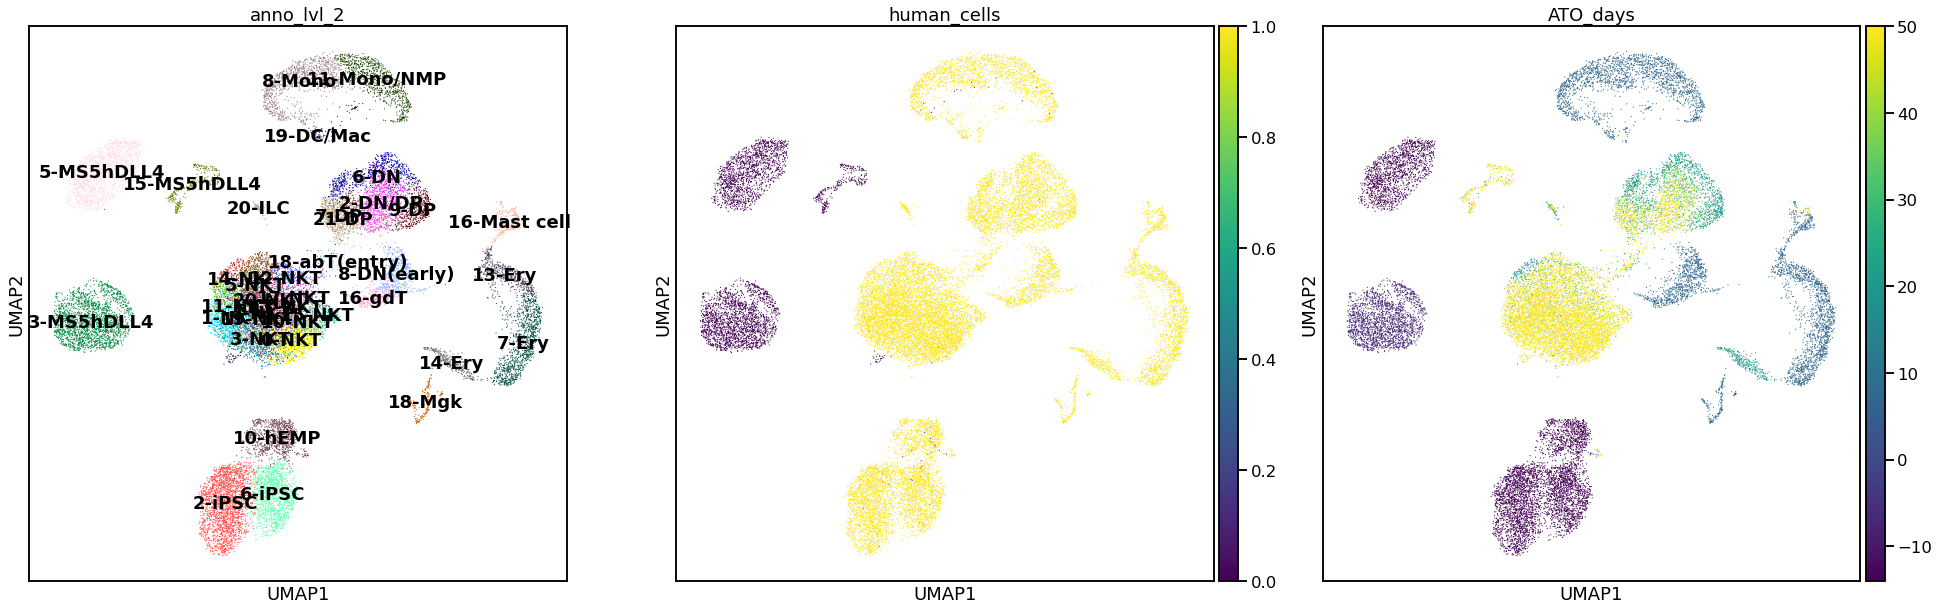

In [94]:
plt.rcParams["figure.figsize"] = [10,10]
ato_adata_cs42.obs["human_cells"] = ato_adata_cs42.obs["human_cells"].astype("int")
sc.pl.umap(ato_adata_cs42, color=["anno_lvl_2", "human_cells", 'ATO_days'], legend_loc='on data')


... storing 'anno_lvl_2_cs42' as categorical


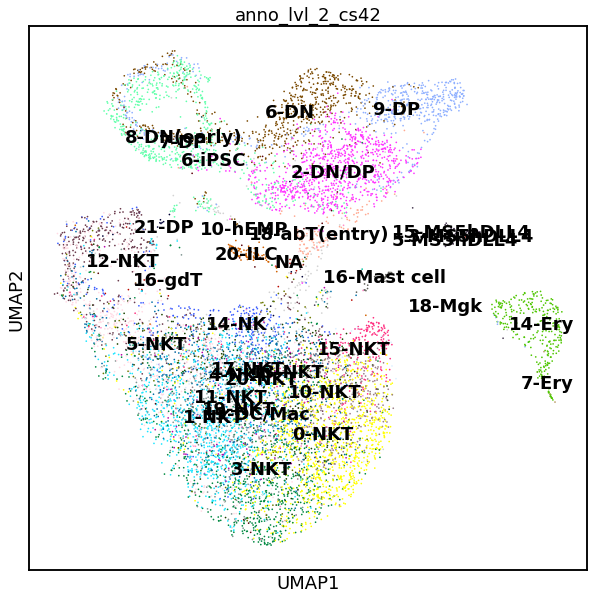

In [95]:
anno_df = ato_adata_cs42.obs.copy()
anno_df.index = ['_'.join([x[1] + "-1", x[0]]) for x in ato_adata_cs42.obs_names.str.split("-")]

ato_adata.obs['anno_lvl_2_cs42'] = [anno_df.loc[x]['anno_lvl_2'] if x in anno_df.index else np.nan for x in ato_adata.obs_names]

ato_adata_pp.obs['anno_lvl_2_cs42'] = ato_adata.obs['anno_lvl_2_cs42'].copy()

sc.pl.umap(ato_adata_pp, color='anno_lvl_2_cs42', legend_loc='on data')

### Add genotyping from souporcell

In [47]:
souporcell_res = pd.read_table('/lustre/scratch117/cellgen/team205/sharedData/cs42/souporcell/ato/ATO/2/clusters.tsv')
souporcell_res.index = souporcell_res["barcode"]

ato_adata.obs['souporcell_barcodes'] = ['-'.join(x[::-1]) for x in ato_adata.obs_names.str.split('_')]

ato_adata.obs['souporcell_status'] = souporcell_res.loc[ato_adata.obs['souporcell_barcodes']]['status'].values
ato_adata.obs['souporcell_assignment'] = souporcell_res.loc[ato_adata.obs['souporcell_barcodes']]['assignment'].values

## Filter out doublets
ato_adata = ato_adata[ato_adata.obs['souporcell_status'] == 'singlet']

## Assign genotype
genotype_dict = {'0':'Kolf','1':'Fiaj'}
ato_adata.obs["cell_line"] = [genotype_dict[x] for x in ato_adata.obs['souporcell_assignment']]
ato_adata.obs["bbk"] = [genotype_dict[x] for x in ato_adata.obs['souporcell_assignment']]

Trying to set attribute `.obs` of view, copying.


### Save for query to reference mapping

In [ ]:
## Gene names 2 ENSEMBL ids
gene_ids = adata_ls[0].var[['gene_ids']]
gene_ids = gene_ids[[x.startswith('GRCh38') for x in gene_ids.gene_ids]]
gene_ids.gene_ids = [x[1] for x in gene_ids.gene_ids.str.split("GRCh38_")]
gene_ids.index = [x[1] for x in gene_ids.index.str.split("GRCh38_")]

ato_adata.var['gene_ids'] = gene_ids.loc[ato_adata.var_names]['gene_ids']
ato_adata.var['gene_names'] = ato_adata.var_names.copy()
ato_adata.var_names = ato_adata.var['gene_ids'].copy()
ato_adata.var.index.name = None

In [48]:
## Check counts 
ato_adata.X.data

array([ 1.,  1.,  1., ...,  7.,  3., 50.], dtype=float32)

In [49]:
ato_adata.write_h5ad('/nfs/team205/ed6/data/Fetal_immune/ATO_query.h5ad')
ato_adata.write_h5ad('/home/jovyan/mount/gdrive/Pan_fetal/data4gpu_node/ATO_query.h5ad')

... storing 'souporcell_status' as categorical
... storing 'souporcell_assignment' as categorical
... storing 'cell_line' as categorical
... storing 'bbk' as categorical


# Train on scVI models

## Mapping 2 HSC_IMMUNE 

On GPU node, running the call:

We merge datasets and rerun embeddings running

### Load output

In [50]:
data_dir = '/nfs/team205/ed6/data/Fetal_immune/'

In [51]:
merged_adata_file = 'ATO_query.mapped2HSC_IMMUNE.withReference.h5ad'
split = "HSC_IMMUNE"
ref_data_dir = '/home/jovyan/mount/gdrive/Pan_fetal/data4gpu_node/'
timestamp = '20210429'

In [52]:
merged_adata = sc.read_h5ad(ref_data_dir + merged_adata_file)

In [53]:
## Filter maternal contaminants
mat_barcodes = pd.read_csv("~/Pan_fetal_immune/metadata/souporcell_results/maternal_barcodes.csv", index_col=0)
mat_barcodes = pd.Series([x.split("-1")[0] for x in mat_barcodes['x']])
reference_obs = merged_adata.obs_names[merged_adata.obs.dataset == "reference"]
exclude_obs = reference_obs[reference_obs.str.strip("-reference").isin(mat_barcodes)]

merged_adata = merged_adata[~merged_adata.obs_names.isin(exclude_obs)].copy()

In [54]:
## Add metadata and annotations for the reference
anno_obs = pd.read_csv(data_dir + "PAN.A01.v01.entire_data_normalised_log.20210429.full_obs.annotated.clean.csv", index_col=0)

## Read annotation groupings
import json
with open('../../metadata/anno_groups.json', 'r') as json_file:
    anno_groups_dict = json.load(json_file)
    
reference_obs = merged_adata.obs_names[merged_adata.obs.dataset == "reference"]

merged_adata.obs["annotation_reference"] = np.nan
merged_adata.obs.loc[reference_obs, "annotation_reference"] = anno_obs.loc[reference_obs.str.strip("-reference")]["anno_lvl_2_final_clean"].values

merged_adata.obs["organ"] = np.nan
merged_adata.obs.loc[reference_obs, "organ"] = anno_obs.loc[reference_obs.str.strip("-reference")]["organ"].values
merged_adata.obs["age"] = np.nan
merged_adata.obs.loc[reference_obs, "age"] = anno_obs.loc[reference_obs.str.strip("-reference")]["age"].values

In [57]:
## Add metadata and annotations for the query
query_obs = merged_adata.obs_names[merged_adata.obs.dataset == "query"]
merged_adata.obs["annotation_query"] = merged_adata.obs["anno_lvl_2_cs42"]

... storing 'annotation_reference' as categorical
... storing 'organ' as categorical


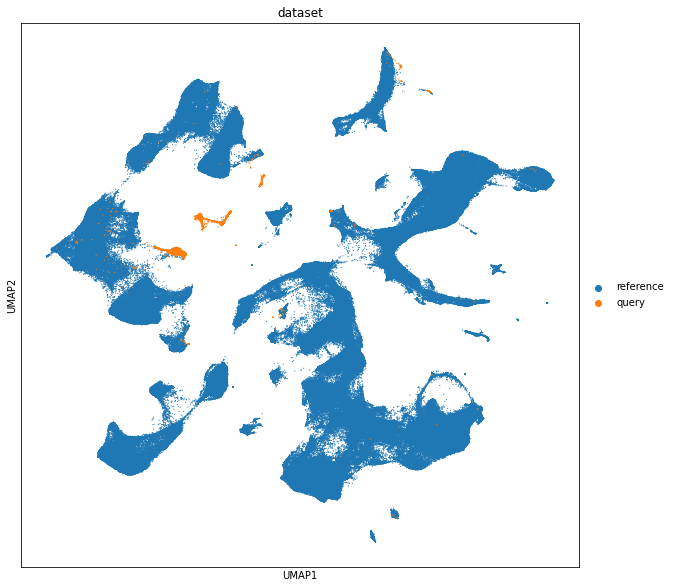

In [58]:
plt.rcParams["figure.figsize"] = [10,10]
sc.pl.umap(merged_adata, color=["dataset"], size=5)

### Plot query and reference annotations

saving figure to file /home/jovyan/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/invivoVSinvitro/scvelo_anno_query.png


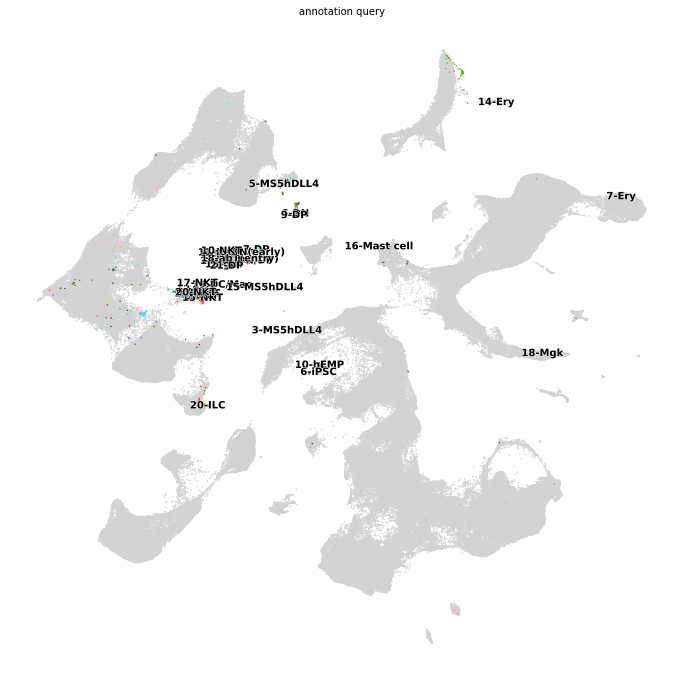

In [61]:
plt.rcParams['figure.figsize'] = [12,12]
anno_labels = merged_adata.obs["annotation_query"][merged_adata.obs["annotation_query"]!="nan"].unique().tolist()
scv.pl.umap(merged_adata, color=["annotation_query"], size=8, legend_loc="on data", groups=anno_labels, title="annotation query", legend_fontsize=10, 
            save="anno_query.png")

saving figure to file /home/jovyan/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/invivoVSinvitro/scvelo_anno_reference.png


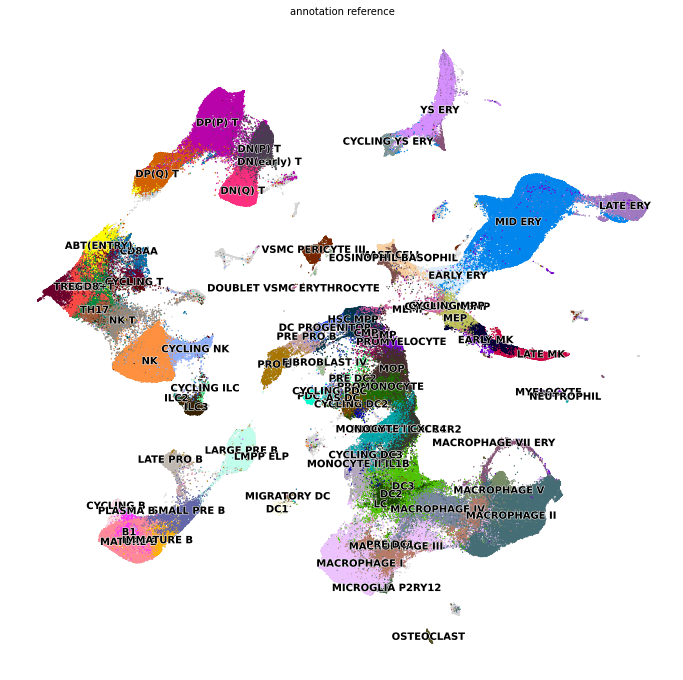

In [62]:
anno_labels = merged_adata.obs["annotation_reference"][merged_adata.obs["annotation_reference"]!="nan"].unique().tolist()
anno_labels = [x for x in anno_labels if type(x)==str]
anno_labels = [x for x in anno_labels if x not in anno_groups_dict["OTHER"]]

scv.pl.umap(merged_adata, color=["annotation_reference"], size=7, legend_loc="on data", groups=anno_labels, 
            legend_fontsize=10,
            title="annotation reference",
           save="anno_reference.png")

### Transfer labels

In [63]:
merged_adata.obs["annotation_reference"] = merged_adata.obs["annotation_reference"].astype("str").replace("nan", np.nan)
map_query_utils.predict_label(merged_adata, anno_col="annotation_reference")

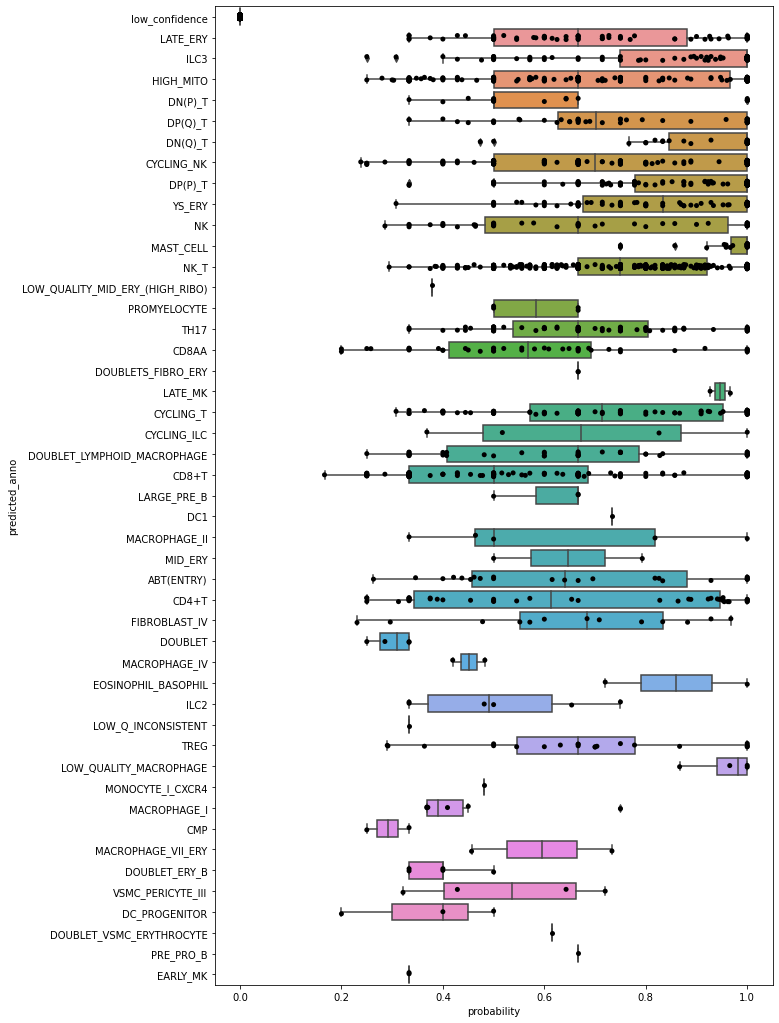

In [64]:
plt.rcParams["figure.figsize"] = [10,18]
map_query_utils.plot_predicted_anno_probability(merged_adata)

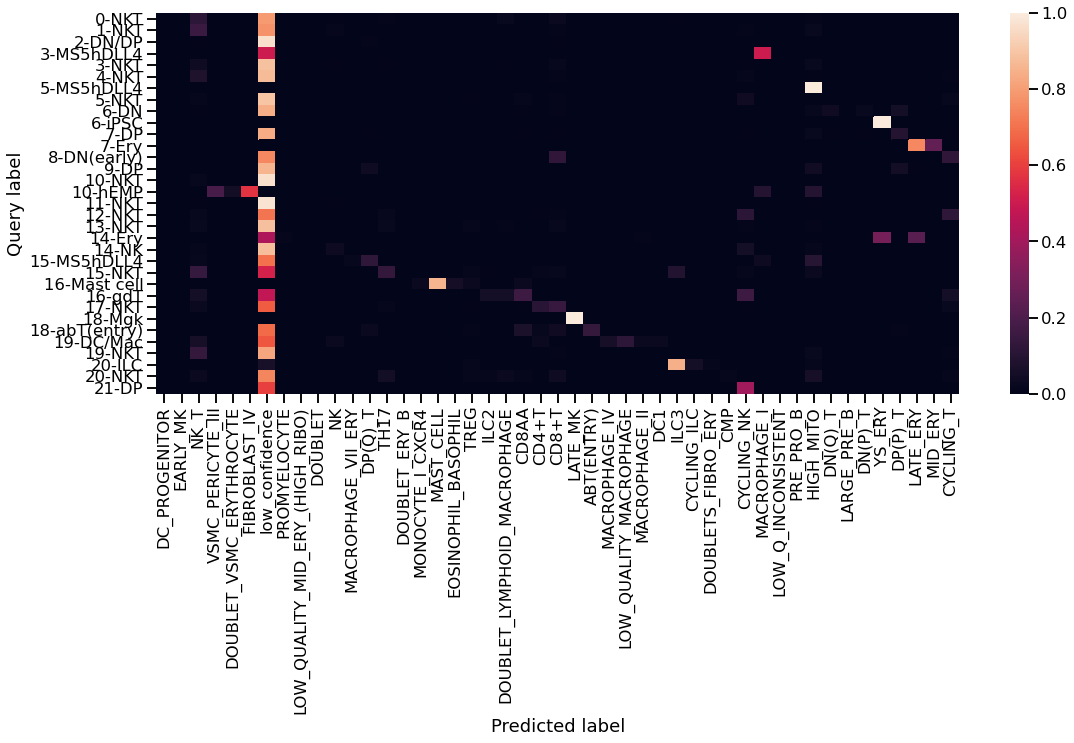

In [65]:
sns.set_context("talk")
query_anno_col="annotation_query"

query_obs = merged_adata.obs_names[merged_adata.obs.dataset == "query"]
empty_query = query_obs[merged_adata[query_obs].obs[query_anno_col]=="nan"]
merged_adata_clean = merged_adata[~merged_adata.obs_names.isin(empty_query)]

plt.rcParams["figure.figsize"] = [18,7]
map_query_utils.plot_confusion_mat(merged_adata_clean, query_anno_col=query_anno_col, show_low_confidence=True)
plt.savefig(figdir + "confusion_label_transfer.pdf", bbox_inches="tight")

### Quantify matching between datasets

In [66]:
import time
start = time.time()
mnn_query, mnn_ref = map_query_utils._find_MNNs(merged_adata)
end = time.time()
print(end - start)

17.468024969100952


In [67]:
map_query_utils._MNN_to_KNN_similarity_ratio(merged_adata, mnn_ref, mnn_query)

... storing 'annotation_reference' as categorical
... storing 'predicted_anno' as categorical


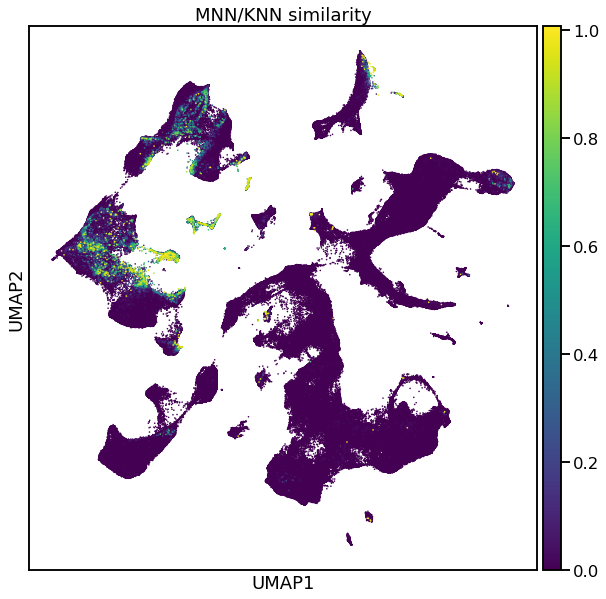

In [68]:
plt.rcParams["figure.figsize"] = [10,10]
sns.set_context("talk")
sc.pl.umap(merged_adata, color="mnn_sim_ratio", size=10, title="MNN/KNN similarity")

In [69]:
mpl.rcParams["figure.figsize"] = [15,4]
_plot_sorted_violin(merged_adata[merged_adata.obs.dataset=="query"], "annotation_query", "mnn_sim_ratio")
_plot_sorted_violin(merged_adata, "annotation_reference", "mnn_sim_ratio")

NameError: name 'mpl' is not defined

### Save outputs

In [ ]:
merged_adata.write_h5ad(data_dir + merged_adata_file)

### Combined similarity & confusion matrix

In [71]:
q_df = merged_adata[merged_adata.obs['dataset'] == 'query'].obs[["mnn_sim_ratio", "predicted_anno", "annotation_query"]]

In [83]:
query_anno_group_lymphoid = {
    "DP/DN":[x for x in q_df.annotation_query.unique() if 'DN' in x or 'DP' in x],
    "NKT cells":[x for x in q_df.annotation_query.unique() if x.endswith("NKT")],
    "NK cells":[x for x in q_df.annotation_query.unique() if x.endswith("NK")],
    'Erythroid cells':[x for x in q_df.annotation_query.unique() if x.endswith("Ery")],
    "Myeloid cells":[x for x in q_df.annotation_query.unique() if 'maso' in x or 'DC' in x or "Mac" in x]
#     "other":[x for x in q_df.annotation_query.unique() if 'doublets' in x],
    }

query_anno_group_lymphoid['other'] = [x for x in q_df.annotation_query.unique() if x not in sum(query_anno_group_lymphoid.values(),[])]
query_anno_group_lymphoid_rev = {x:g for g,a in query_anno_group_lymphoid.items() for x in a}

# ref_anno_group_lymphoid = {
#     "NK cells":[x for x in q_df.predicted_anno.unique() if x.endswith("NK")],
#     "ILCs":[x for x in q_df.predicted_anno.unique() if x.startswith("ILC")],
#     "B cells":[x for x in q_df.predicted_anno.unique() if x.endswith("B") or x=="B1"],
#     "T cells":[x for x in q_df.predicted_anno.unique() if x.endswith("T") or x=="ABT(ENTRY)" or x=="CD8AA"],
#     'low_confidence':['low_confidence']
#     }

ref_anno_group_lymphoid = anno_groups_dict.copy()
ref_anno_group_lymphoid['low_confidence'] = ['low_confidence']

ref_anno_group_lymphoid['other'] = [x for x in q_df.predicted_anno.unique() if x not in sum(ref_anno_group_lymphoid.values(),[])]
ref_anno_group_lymphoid_rev = {x:g for g,a in ref_anno_group_lymphoid.items() for x in a}

q_df['annotation_query_group'] = [query_anno_group_lymphoid_rev[x] for x in q_df['annotation_query']]
q_df['predicted_anno_group'] = [ref_anno_group_lymphoid_rev[x] for x in q_df['predicted_anno']]

`summarise()` has grouped output by 'predicted_anno', 'annotation_query', 'annotation_query_group', 'predicted_anno_group'. You can override using the `.groups` argument.


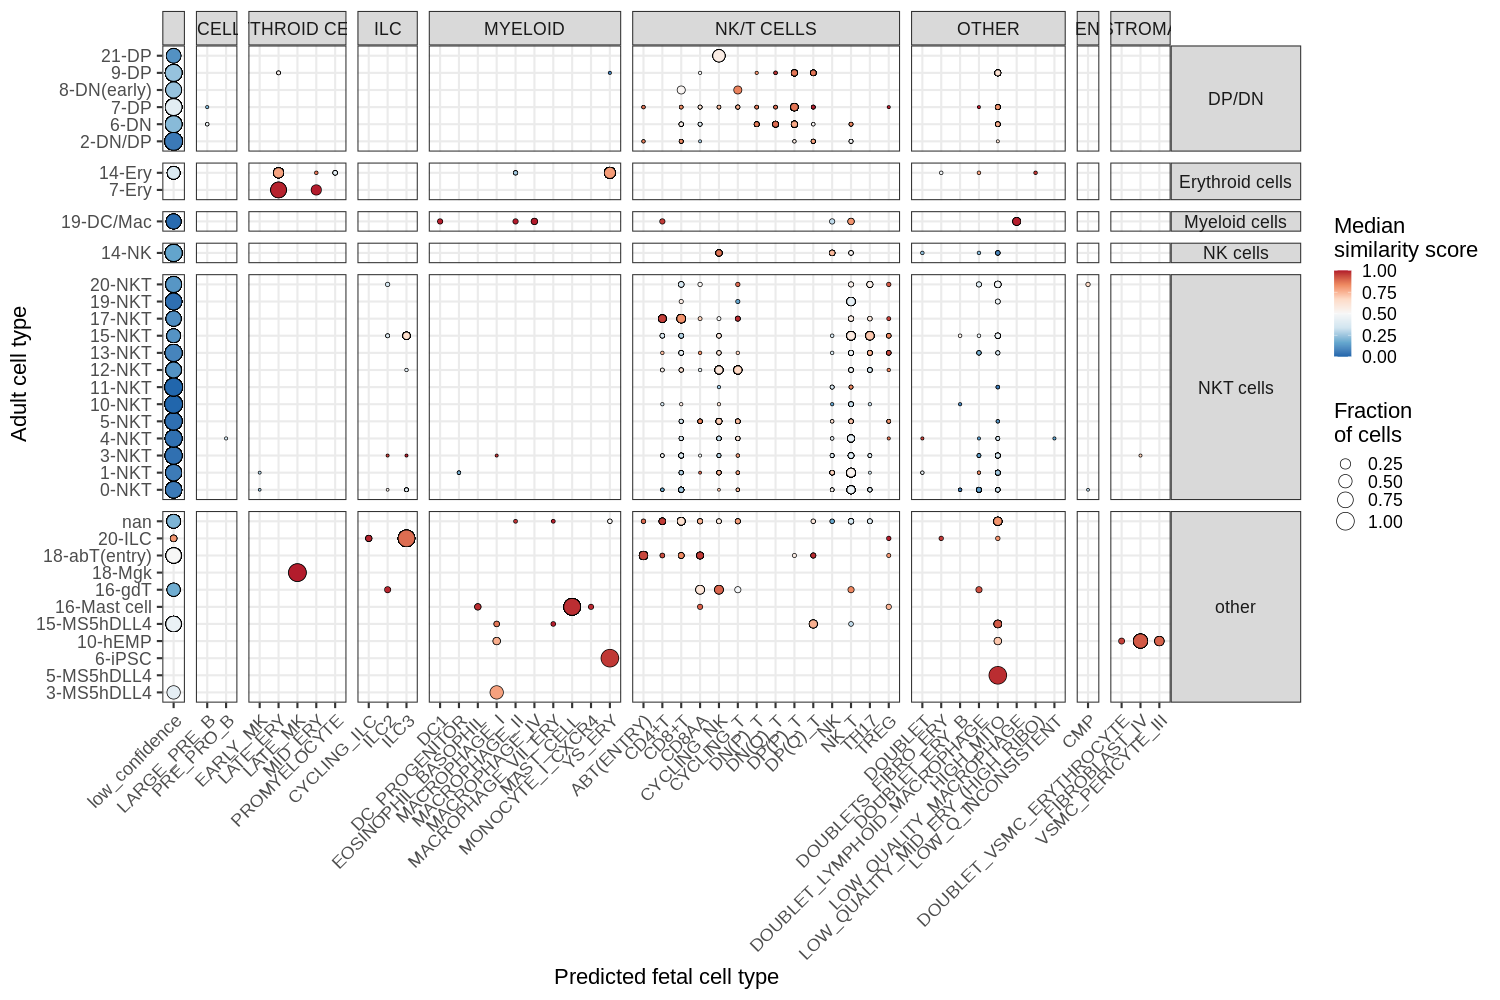

In [86]:
%%R -i q_df -h 1000 -w 1500 -i figdir
q_df %>%
    group_by(annotation_query) %>%
    mutate(tot_cells=n()) %>%
    ungroup() %>%
    group_by(predicted_anno, annotation_query, annotation_query_group, predicted_anno_group) %>%
    summarise(frac_cells=n()/tot_cells, median_sim_score=median(mnn_sim_ratio)) %>%
    ungroup() %>%
#     filter(annotation_query_group != 'other' & predicted_anno_group != 'other' ) %>%
#     mutate(annotation_query_group=factor(annotation_query_group, levels=c('NK cells', 'ILCs', 'B cells', 'T cells'))) %>%
    mutate(predicted_anno_group = ifelse(predicted_anno_group=="low_confidence", '', predicted_anno_group)) %>%
#     mutate(predicted_anno_group=factor(predicted_anno_group, levels=c('NK cells', 'ILCs', 'B cells', 'T cells', ''))) %>%
    ggplot(aes(predicted_anno, annotation_query)) +
    scale_size(range=c(1,8), name="Fraction\nof cells") +
    geom_point(aes(size=frac_cells, fill=median_sim_score), shape=21) +
    scale_fill_distiller(palette="RdBu", direction=-1, name='Median\nsimilarity score') +
    facet_grid(annotation_query_group~predicted_anno_group, space="free", scales='free') +
    xlab("Predicted fetal cell type") + ylab("Adult cell type") +
    theme_bw(base_size=22) +
    theme(axis.text.x=element_text(angle=45, hjust=1), strip.text.y=element_text(angle=0)) 
#     ggsave(paste0(figdir, "adult_confusion_similarity_dotplot.pdf"), width=15, height=10)

In [103]:
ato_adata_pp.var_names = ato_adata_pp.var['gene_names'].values

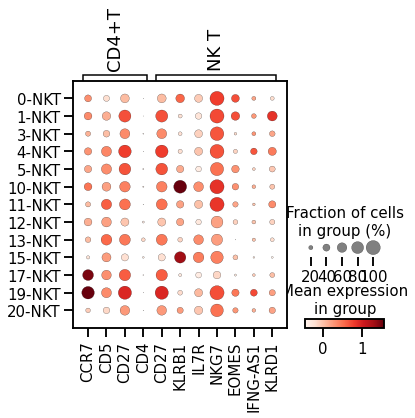

In [127]:
nkt_markers = pd.read_csv("../../metadata/marker_genes/NKT_marker_genes_09072021_clean.csv", index_col=0)
nkt_markers_dict = {ct:nkt_markers[nkt_markers['anno_lvl_2'] == ct]['gene'].tolist() for ct in nkt_markers['anno_lvl_2'].unique()}

cts_oi = ["CD4+T", "NK T"]

sc.pl.dotplot(ato_adata_pp[ato_adata_pp.obs['anno_lvl_2_cs42'].isin(query_anno_group_lymphoid['NKT cells'])], 
              {k:v for k,v in nkt_markers_dict.items() if k in cts_oi}, 
              groupby='anno_lvl_2_cs42')

## Mapping 2 lymphoid

### Load output

In [128]:
data_dir = '/nfs/team205/ed6/data/Fetal_immune/'

merged_adata_file = 'ATO_query.mapped2LYMPHOID.withReference.h5ad'
split = "LYMPHOID"
ref_data_dir = '/home/jovyan/mount/gdrive/Pan_fetal/data4gpu_node/'
timestamp = '20210429'

In [129]:
merged_adata_2 = sc.read_h5ad(ref_data_dir + merged_adata_file)

In [131]:
merged_adata = merged_adata_2.copy()

In [132]:
## Filter maternal contaminants
mat_barcodes = pd.read_csv("~/Pan_fetal_immune/metadata/souporcell_results/maternal_barcodes.csv", index_col=0)
mat_barcodes = pd.Series([x.split("-1")[0] for x in mat_barcodes['x']])
reference_obs = merged_adata.obs_names[merged_adata.obs.dataset == "reference"]
exclude_obs = reference_obs[reference_obs.str.strip("-reference").isin(mat_barcodes)]

merged_adata = merged_adata[~merged_adata.obs_names.isin(exclude_obs)].copy()

In [133]:
## Add metadata and annotations for the reference
anno_obs = pd.read_csv(data_dir + "PAN.A01.v01.entire_data_normalised_log.20210429.full_obs.annotated.clean.csv", index_col=0)

## Read annotation groupings
import json
with open('../../metadata/anno_groups.json', 'r') as json_file:
    anno_groups_dict = json.load(json_file)
    
reference_obs = merged_adata.obs_names[merged_adata.obs.dataset == "reference"]

merged_adata.obs["annotation_reference"] = np.nan
merged_adata.obs.loc[reference_obs, "annotation_reference"] = anno_obs.loc[reference_obs.str.strip("-reference")]["anno_lvl_2_final_clean"].values

merged_adata.obs["organ"] = np.nan
merged_adata.obs.loc[reference_obs, "organ"] = anno_obs.loc[reference_obs.str.strip("-reference")]["organ"].values
merged_adata.obs["age"] = np.nan
merged_adata.obs.loc[reference_obs, "age"] = anno_obs.loc[reference_obs.str.strip("-reference")]["age"].values

In [134]:
## Add metadata and annotations for the query
query_obs = merged_adata.obs_names[merged_adata.obs.dataset == "query"]
merged_adata.obs["annotation_query"] = merged_adata.obs["anno_lvl_2_cs42"]

... storing 'annotation_reference' as categorical
... storing 'organ' as categorical


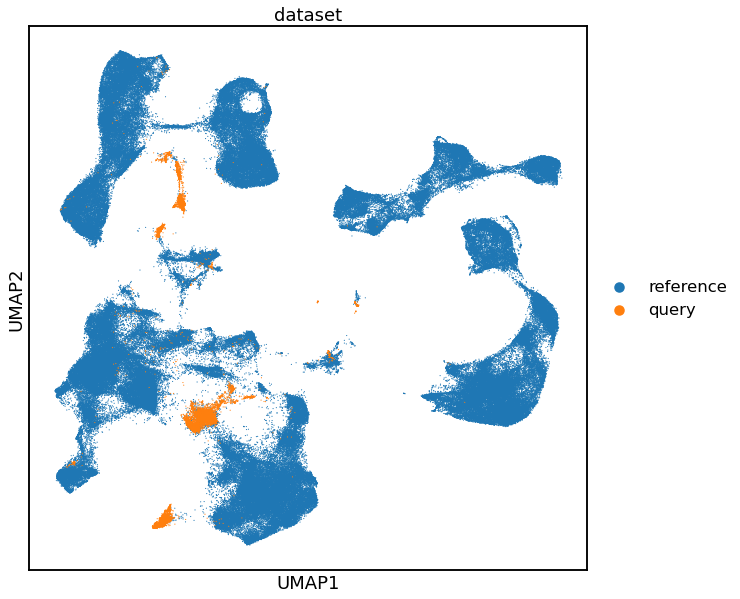

In [135]:
plt.rcParams["figure.figsize"] = [10,10]
sc.pl.umap(merged_adata, color=["dataset"], size=5)

### Plot query and reference annotations

saving figure to file /home/jovyan/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/invivoVSinvitro/scvelo_anno_query_lymphoid.png


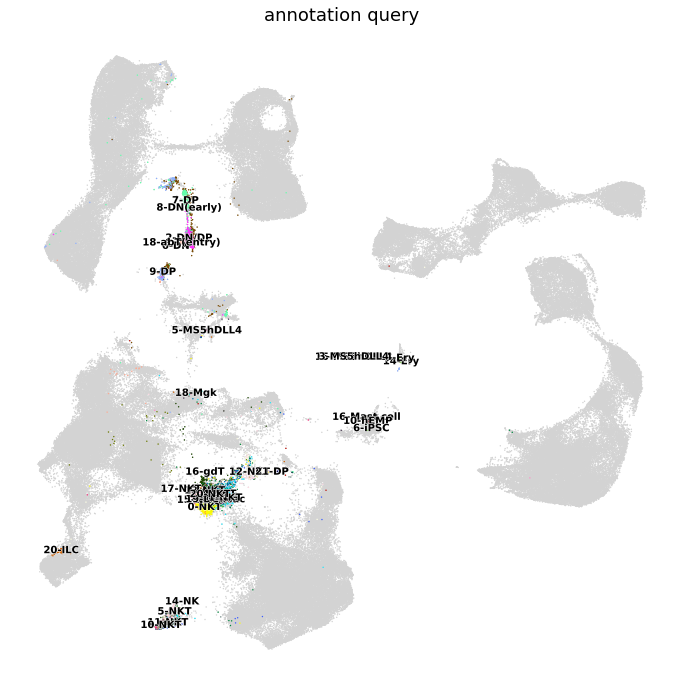

In [136]:
plt.rcParams['figure.figsize'] = [12,12]
anno_labels = merged_adata.obs["annotation_query"][merged_adata.obs["annotation_query"]!="nan"].unique().tolist()
scv.pl.umap(merged_adata, color=["annotation_query"], size=8, legend_loc="on data", groups=anno_labels, title="annotation query", legend_fontsize=10, 
            save="anno_query_lymphoid.png")

saving figure to file /home/jovyan/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/invivoVSinvitro/scvelo_anno_reference_lymphoid.png


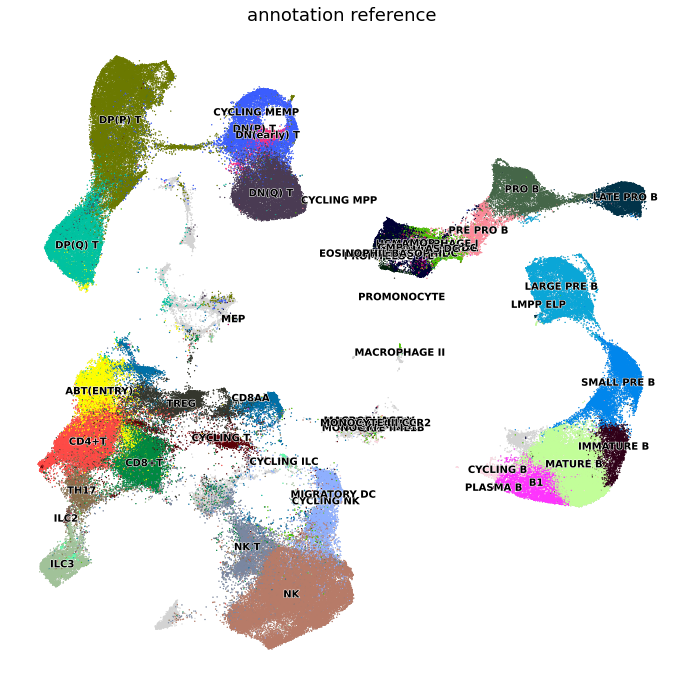

In [137]:
anno_labels = merged_adata.obs["annotation_reference"][merged_adata.obs["annotation_reference"]!="nan"].unique().tolist()
anno_labels = [x for x in anno_labels if type(x)==str]
anno_labels = [x for x in anno_labels if x not in anno_groups_dict["OTHER"]]

scv.pl.umap(merged_adata, color=["annotation_reference"], size=7, legend_loc="on data", groups=anno_labels, 
            legend_fontsize=10,
            title="annotation reference",
           save="anno_reference_lymphoid.png")

### Transfer labels

In [138]:
merged_adata.obs["annotation_reference"] = merged_adata.obs["annotation_reference"].astype("str").replace("nan", np.nan)
map_query_utils.predict_label(merged_adata, anno_col="annotation_reference")

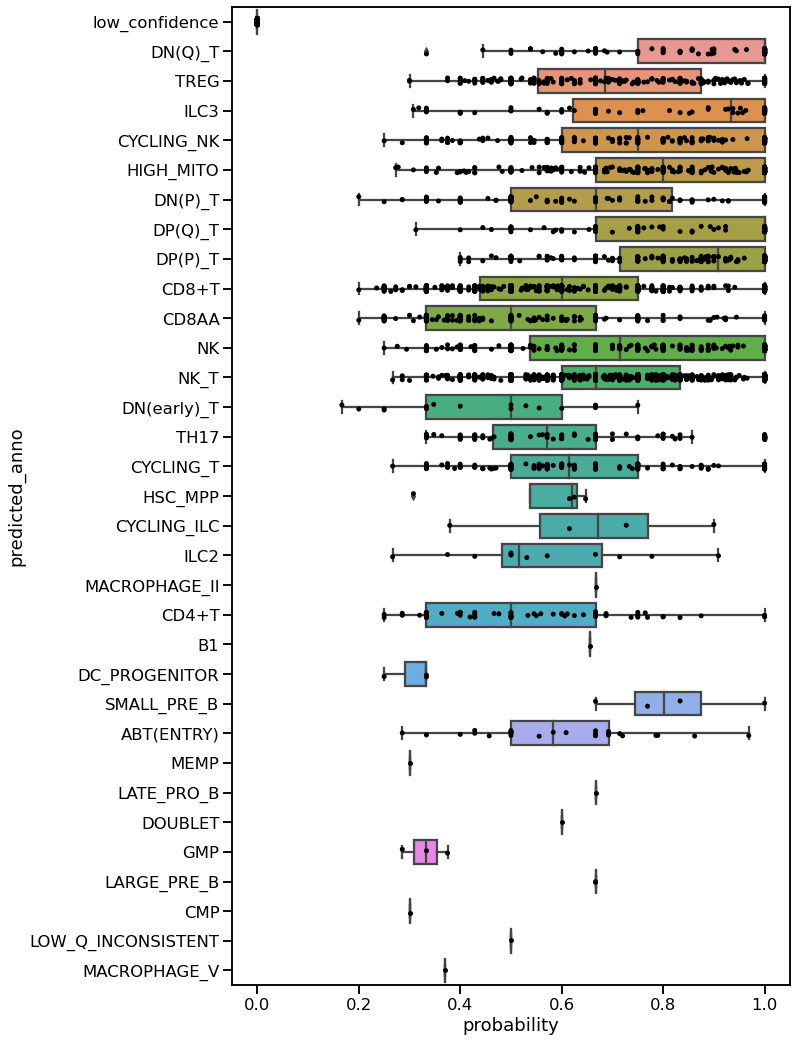

In [139]:
plt.rcParams["figure.figsize"] = [10,18]
map_query_utils.plot_predicted_anno_probability(merged_adata)

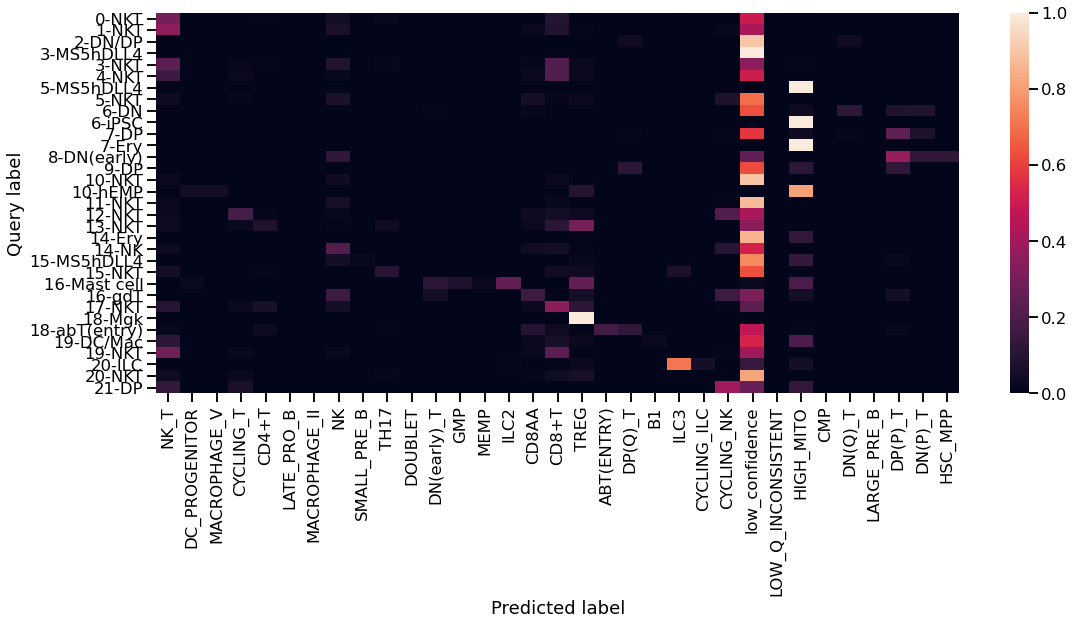

In [140]:
sns.set_context("talk")
query_anno_col="annotation_query"

query_obs = merged_adata.obs_names[merged_adata.obs.dataset == "query"]
empty_query = query_obs[merged_adata[query_obs].obs[query_anno_col]=="nan"]
merged_adata_clean = merged_adata[~merged_adata.obs_names.isin(empty_query)]

plt.rcParams["figure.figsize"] = [18,7]
map_query_utils.plot_confusion_mat(merged_adata_clean, query_anno_col=query_anno_col, show_low_confidence=True)
plt.savefig(figdir + "confusion_label_transfer_lymphoid.pdf", bbox_inches="tight")

### Quantify matching between datasets

In [141]:
import time
start = time.time()
mnn_query, mnn_ref = map_query_utils._find_MNNs(merged_adata)
end = time.time()
print(end - start)

13.698395490646362


In [142]:
map_query_utils._MNN_to_KNN_similarity_ratio(merged_adata, mnn_ref, mnn_query)

... storing 'annotation_reference' as categorical
... storing 'predicted_anno' as categorical


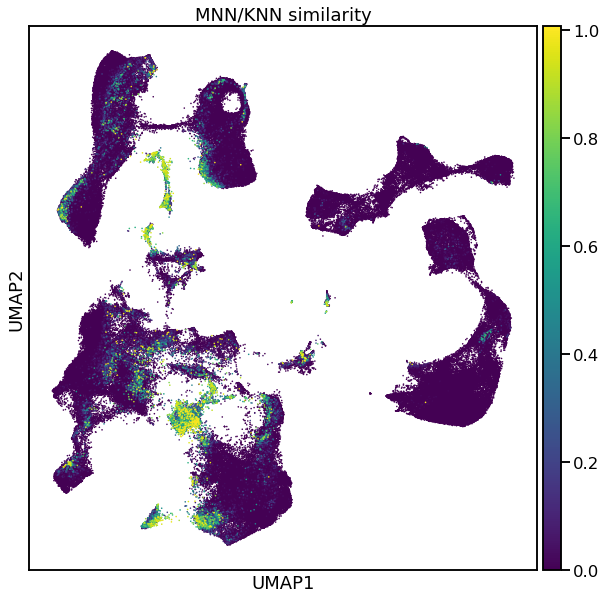

In [143]:
plt.rcParams["figure.figsize"] = [10,10]
sns.set_context("talk")
sc.pl.umap(merged_adata, color="mnn_sim_ratio", size=10, title="MNN/KNN similarity")

### Save outputs

In [145]:
merged_adata.write_h5ad(data_dir + merged_adata_file)

### Combined similarity & confusion matrix

In [146]:
q_df = merged_adata[merged_adata.obs['dataset'] == 'query'].obs[["mnn_sim_ratio", "predicted_anno", "annotation_query"]]

In [147]:
query_anno_group_lymphoid = {
    "DP/DN":[x for x in q_df.annotation_query.unique() if 'DN' in x or 'DP' in x],
    "NKT cells":[x for x in q_df.annotation_query.unique() if x.endswith("NKT")],
    "NK cells":[x for x in q_df.annotation_query.unique() if x.endswith("NK")],
    'Erythroid cells':[x for x in q_df.annotation_query.unique() if x.endswith("Ery")],
    "Myeloid cells":[x for x in q_df.annotation_query.unique() if 'maso' in x or 'DC' in x or "Mac" in x]
#     "other":[x for x in q_df.annotation_query.unique() if 'doublets' in x],
    }

query_anno_group_lymphoid['other'] = [x for x in q_df.annotation_query.unique() if x not in sum(query_anno_group_lymphoid.values(),[])]
query_anno_group_lymphoid_rev = {x:g for g,a in query_anno_group_lymphoid.items() for x in a}

ref_anno_group_lymphoid = {
    "NK cells":[x for x in q_df.predicted_anno.unique() if x.endswith("NK")],
    "ILCs":[x for x in q_df.predicted_anno.unique() if x.startswith("ILC")],
    "B cells":[x for x in q_df.predicted_anno.unique() if x.endswith("B") or x=="B1"],
    "T cells":[x for x in q_df.predicted_anno.unique() if x.endswith("T") or x=="ABT(ENTRY)" or x=="CD8AA"],
    'low_confidence':['low_confidence']
    }

# ref_anno_group_lymphoid = anno_groups_dict.copy()
# ref_anno_group_lymphoid['low_confidence'] = ['low_confidence']

ref_anno_group_lymphoid['other'] = [x for x in q_df.predicted_anno.unique() if x not in sum(ref_anno_group_lymphoid.values(),[])]
ref_anno_group_lymphoid_rev = {x:g for g,a in ref_anno_group_lymphoid.items() for x in a}

q_df['annotation_query_group'] = [query_anno_group_lymphoid_rev[x] for x in q_df['annotation_query']]
q_df['predicted_anno_group'] = [ref_anno_group_lymphoid_rev[x] for x in q_df['predicted_anno']]

`summarise()` has grouped output by 'predicted_anno', 'annotation_query', 'annotation_query_group', 'predicted_anno_group'. You can override using the `.groups` argument.


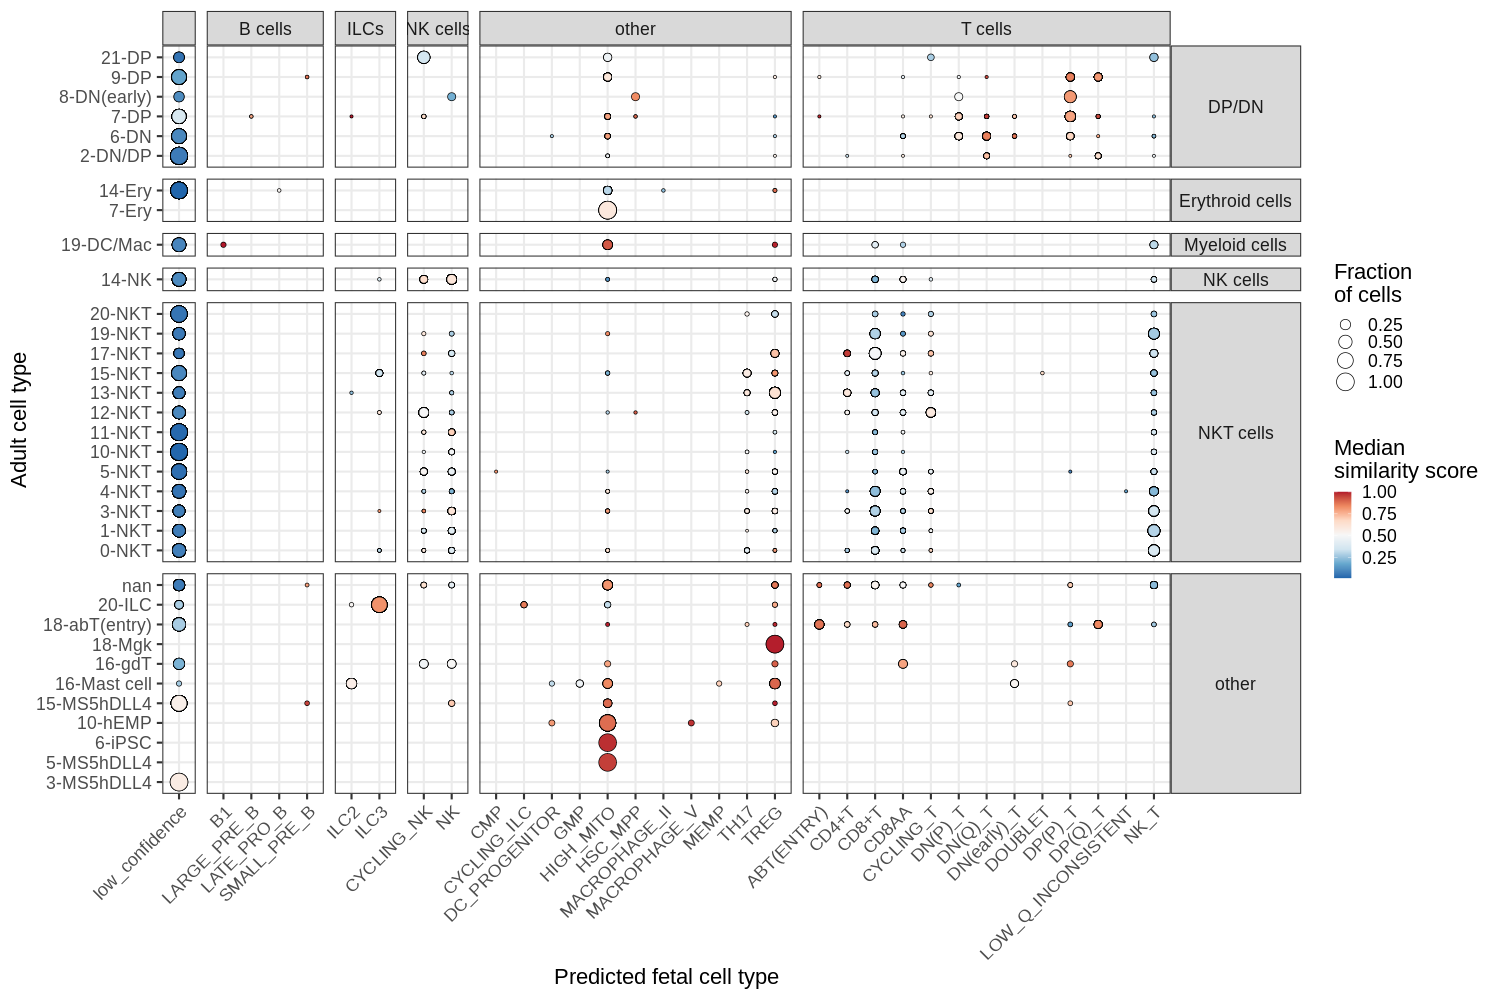

In [148]:
%%R -i q_df -h 1000 -w 1500 -i figdir
q_df %>%
    group_by(annotation_query) %>%
    mutate(tot_cells=n()) %>%
    ungroup() %>%
    group_by(predicted_anno, annotation_query, annotation_query_group, predicted_anno_group) %>%
    summarise(frac_cells=n()/tot_cells, median_sim_score=median(mnn_sim_ratio)) %>%
    ungroup() %>%
#     filter(annotation_query_group != 'other' & predicted_anno_group != 'other' ) %>%
#     mutate(annotation_query_group=factor(annotation_query_group, levels=c('NK cells', 'ILCs', 'B cells', 'T cells'))) %>%
    mutate(predicted_anno_group = ifelse(predicted_anno_group=="low_confidence", '', predicted_anno_group)) %>%
#     mutate(predicted_anno_group=factor(predicted_anno_group, levels=c('NK cells', 'ILCs', 'B cells', 'T cells', ''))) %>%
    ggplot(aes(predicted_anno, annotation_query)) +
    scale_size(range=c(1,8), name="Fraction\nof cells") +
    geom_point(aes(size=frac_cells, fill=median_sim_score), shape=21) +
    scale_fill_distiller(palette="RdBu", direction=-1, name='Median\nsimilarity score') +
    facet_grid(annotation_query_group~predicted_anno_group, space="free", scales='free') +
    xlab("Predicted fetal cell type") + ylab("Adult cell type") +
    theme_bw(base_size=22) +
    theme(axis.text.x=element_text(angle=45, hjust=1), strip.text.y=element_text(angle=0)) 
#     ggsave(paste0(figdir, "adult_confusion_similarity_dotplot.pdf"), width=15, height=10)

## Visualize results on ATO embedding

In [183]:
ato_adata_pp.obs['predicted_anno'] = merged_adata.obs.loc[ato_adata_pp.obs_names + "-query", 'predicted_anno'].values
ato_adata_pp.obs['similarity_score'] = merged_adata.obs.loc[ato_adata_pp.obs_names + "-query", 'mnn_sim_ratio'].values

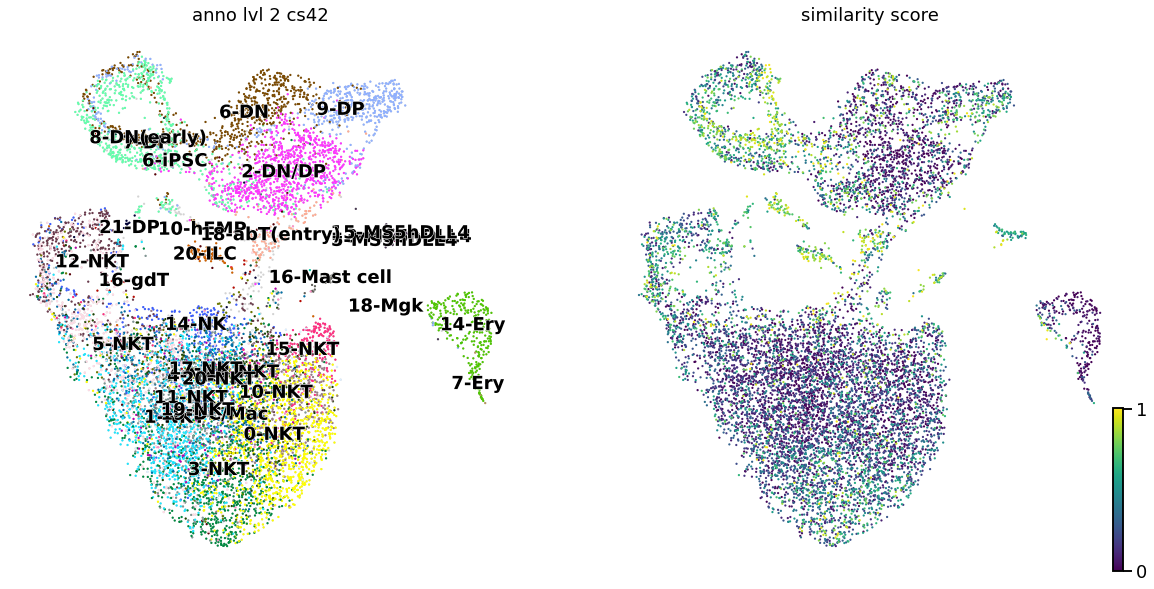

In [189]:
scv.pl.umap(ato_adata_pp, color=['anno_lvl_2_cs42', 'similarity_score'], legend_loc='on data', size=20)

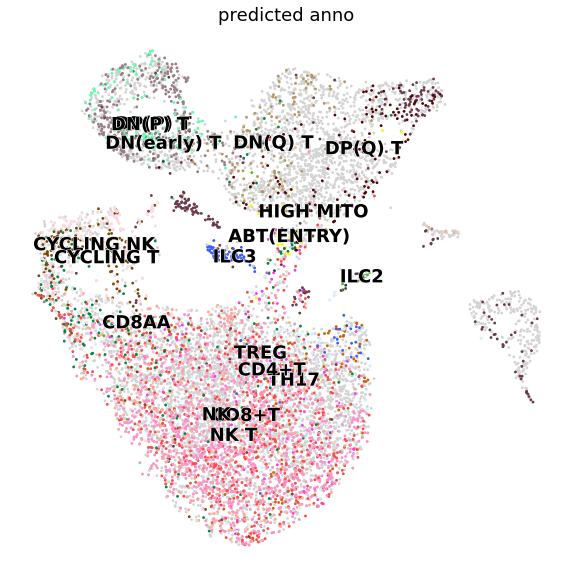

In [195]:
keep_anno = ato_adata_pp.obs['predicted_anno'].value_counts()[1:][ato_adata_pp.obs['predicted_anno'].value_counts()[1:] > 10].index.tolist()
scv.pl.umap(ato_adata_pp, color=['predicted_anno'], legend_loc='on data', size=30, groups=keep_anno)

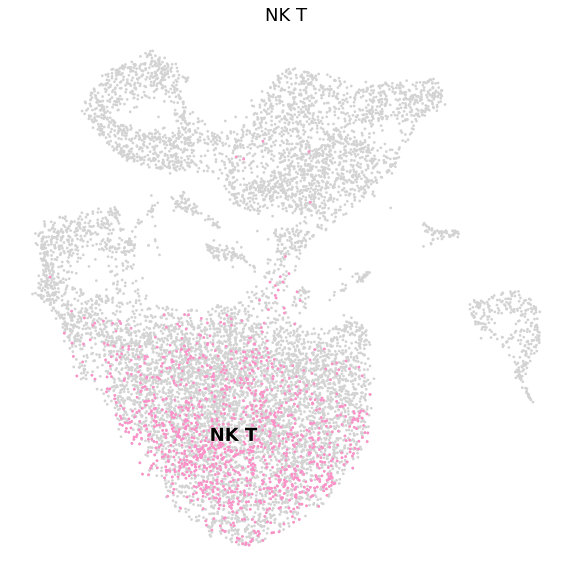

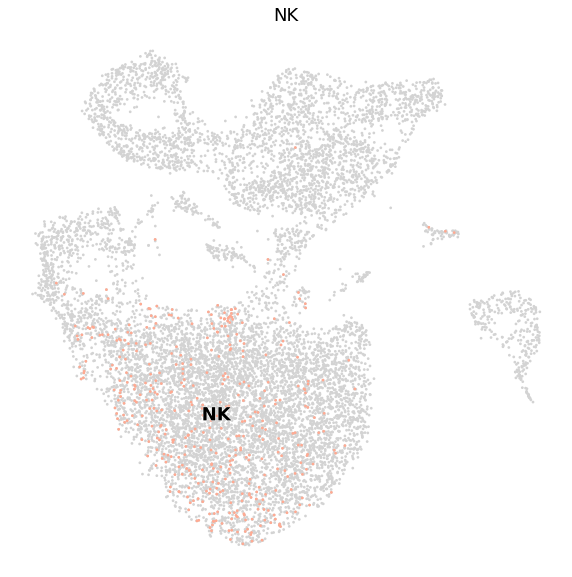

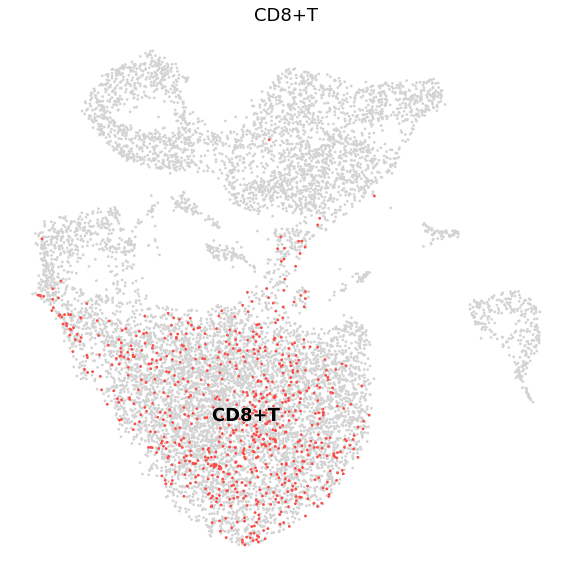

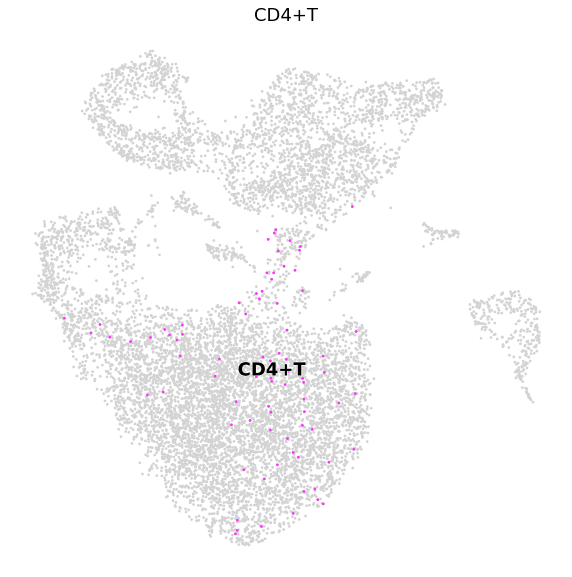

In [188]:
for ct in ['NK_T','NK', "CD8+T", "CD4+T"]:
    scv.pl.umap(ato_adata_pp, color=['predicted_anno'], legend_loc='on data', size=30, 
                groups=[ct])